# Time Series Analysis and Forecasting of US Crude Oil Imports

In [227]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import tensorflow as tf

## Import the US Crude Oil Import Data

Dataset downloaded from ['github.com/rishabah89007'](https://github.com/rishabh89007/Time_Series_Datasets/blob/main/Imports%20Crude%20Oil.csv)

In [190]:
df = pd.read_csv('imports_crude_oil.csv')
df.head()

,Unnamed: 0,"Imports of all grades of crude oil from World to Total U.S. (US), Monthly (thousand barrels)"
0,2009 01,317275
1,2009 02,262339
2,2009 03,303897
3,2009 04,285934
4,2009 05,281147


In [191]:
df.tail()

,Unnamed: 0,"Imports of all grades of crude oil from World to Total U.S. (US), Monthly (thousand barrels)"
140,2020 09,161926
141,2020 10,164494
142,2020 11,168655
143,2020 12,178597
144,2021 01,181197


In [192]:
df.columns = ['date', 'crude_oil_imports']

In [193]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   date               145 non-null    object
 1   crude_oil_imports  145 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [194]:
df.isna().sum()

date                 0
crude_oil_imports    0
dtype: int64

In [195]:
df.shape

(145, 2)

In [196]:
fig = px.line(df, x='date', y='crude_oil_imports', title='US Crude Oil Imports Over Time',
             width=800, height=400)
fig.update_traces(line_color='#4169E1')
fig.show()

## Convert the Date Column into Separate Columns of Year and Month

In [197]:
def get_features(dataframe):
    dataframe['date'] = pd.to_datetime(dataframe['date'])
    dataframe['year'] = dataframe.date.dt.year
    dataframe['month'] = dataframe.date.dt.month
    
    return dataframe

In [198]:
df = get_features(df)
df.head()

,date,crude_oil_imports,year,month
0,2009-01-01,317275,2009,1
1,2009-02-01,262339,2009,2
2,2009-03-01,303897,2009,3
3,2009-04-01,285934,2009,4
4,2009-05-01,281147,2009,5


## Plot the Imports By Year

Text(0.5, 1.0, 'US Crude Oil Imports By Year')

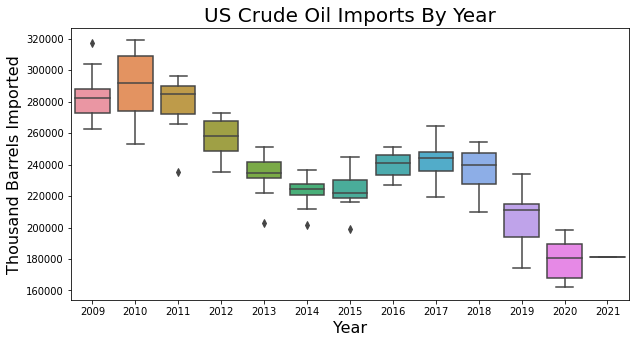

In [199]:
plt.figure(figsize=(10, 5))
ax = sns.boxplot(x='year', y='crude_oil_imports', data=df)
ax.set_xlabel('Year', fontsize=16)
ax.set_ylabel('Thousand Barrels Imported', fontsize=16)
ax.set_title('US Crude Oil Imports By Year', fontsize=20)


## Plot the Imports By Month

Text(0.5, 1.0, 'US Crude Oil Imports By Month')

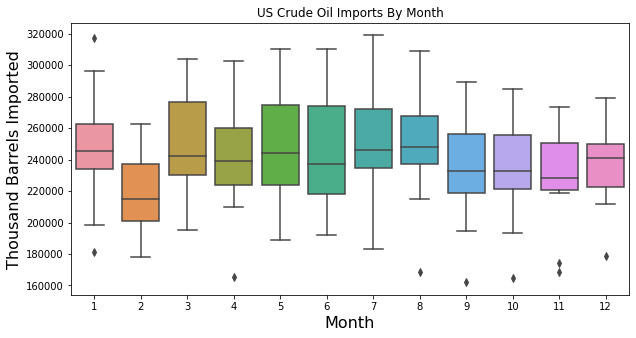

In [200]:
plt.figure(figsize=(10, 5))
ax = sns.boxplot(x='month', y='crude_oil_imports', data=df)
ax.set_xlabel('Month', fontsize=16)
ax.set_ylabel('Thousand Barrels Imported', fontsize=16)
ax.set_title('US Crude Oil Imports By Month')

## Create Rolling Averages of Imports

By taking and ploting a rolling average, the general trend of the data is more obvious. As well, the rolling average can be used as a mid point for creating standard deviations for outlier detection.

In [201]:
df['rolling_10'] = df['crude_oil_imports'].rolling(window=10).mean()

In [202]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['date'], y=df['crude_oil_imports'], mode='lines', name='Raw Data',
                        line=dict(color='#bec2ed')))
fig.add_trace(go.Scatter(x=df['date'], y=df['rolling_10'], mode='lines', name='Rolling 10',
                        line=dict(color='#d99543', dash='dash')))
fig.update_layout(width=800, height=500)

## Use Statsmodels to Show Seasonality

In [203]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [204]:
seasonal_df = df[['date','crude_oil_imports']].copy(deep=True)
seasonal_df = seasonal_df.set_index('date')
seasonal_df.head()

,crude_oil_imports
date,
2009-01-01,317275
2009-02-01,262339
2009-03-01,303897
2009-04-01,285934
2009-05-01,281147


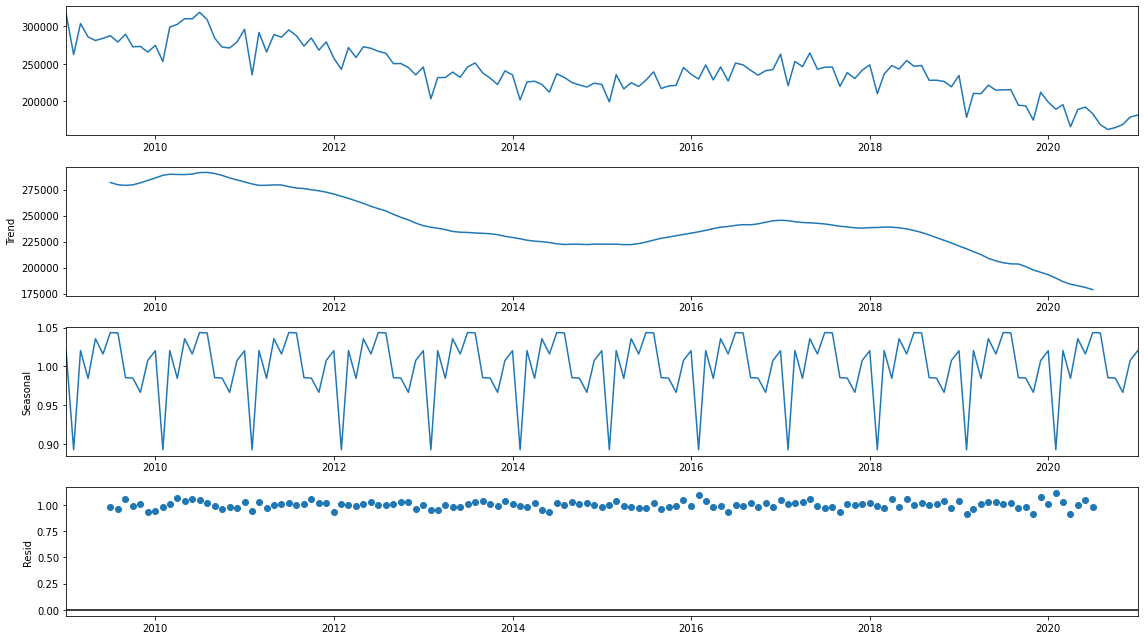

In [205]:
result = seasonal_decompose(seasonal_df, model='multiplicative', period=12)
fig = result.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()


## Analysis of the Stats Model Seasonality
The trend line is very similar to the rolling window line created before and shows that the number of imports is declining in general though it had an uptick from 2016-2018.

The seasonal trend shows that within the year there is a consistent drop of imports at the beginning of the year and in the middle of the year. The peaks of seasonal imports are around the beginning of Spring and the beginning of Fall.

The residuals shows there is a significant amount of noise in the data that does not follow the seasonality and trend. As well, the data in 2020 has more variance in the noise.

In [206]:
from fbprophet import Prophet

In [207]:
prophet_df = df[['date', 'crude_oil_imports']]
prophet_df.columns = ['ds', 'y']

In [208]:
model = Prophet()
model.fit(prophet_df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [209]:
# make a dataframe for future dates for the next 12 months, set frequency to MS for months
future_df = model.make_future_dataframe(periods=12, freq='MS')

# confirm there is an extra year of dates
future_df.tail()

,ds
152,2021-09-01
153,2021-10-01
154,2021-11-01
155,2021-12-01
156,2022-01-01


In [210]:
# make predictions
forecast_df = model.predict(future_df)
forecast_df.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
152,2021-09-01,151743.060806,133698.995102,159506.211018,150106.617193,153200.839785,-4889.801514,-4889.801514,-4889.801514,-4889.801514,-4889.801514,-4889.801514,0.0,0.0,0.0,146853.259292
153,2021-10-01,149606.934996,130627.864449,156873.430591,147639.670835,151531.912812,-5622.374879,-5622.374879,-5622.374879,-5622.374879,-5622.374879,-5622.374879,0.0,0.0,0.0,143984.560117
154,2021-11-01,147399.604993,126953.200257,152931.098714,145117.581385,149679.975736,-7241.159300,-7241.159300,-7241.159300,-7241.159300,-7241.159300,-7241.159300,0.0,0.0,0.0,140158.445693
155,2021-12-01,145263.479183,131477.684973,156598.364239,142634.365073,147961.690575,-1240.068583,-1240.068583,-1240.068583,-1240.068583,-1240.068583,-1240.068583,0.0,0.0,0.0,144023.410600
156,2022-01-01,143056.149179,136738.877690,163307.068658,139932.562997,146187.620745,7131.112693,7131.112693,7131.112693,7131.112693,7131.112693,7131.112693,0.0,0.0,0.0,150187.261872


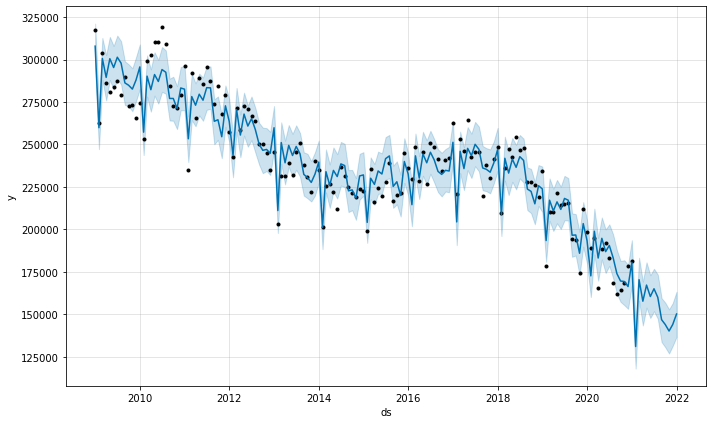

In [211]:
# plot the results of the past data and future forecast
fig1 = model.plot(forecast_df)

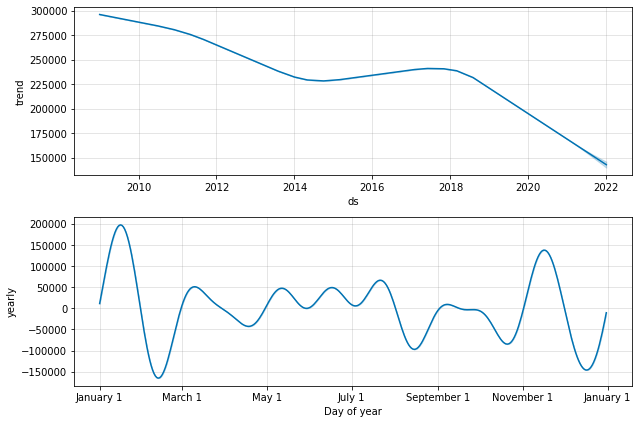

In [212]:
# breakdown the various components
fig2 = model.plot_components(forecast_df)

## Analysis of the FB Prophet on the Raw Data

The general trend is similar to what was seen from the statsmodel analysis. The seasonal trend is not very similar to the statsmodel seasonal trend and perhaps gives a better understanding of the actual seasonal trend. The seasonal trend using statsmodel created a seasonal trend that occurred twice a year.

In the FB Prophet model, there seems to be **two big spikes** in crude oil imports, one in **February** and one in **November**. As well, the **two major dips** are in **February** and **December**.


## Use LSTM For Forecasting

### Preprocess the Data

In [216]:
# drop the nan values created from the rolling window
df = df.dropna()

In [217]:
ds = df[['rolling_10']].values

In [218]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))

In [219]:
ds = scaler.fit_transform(ds)

In [220]:
# split the training and testing to 75% and 25%
train_size = int(len(ds) * 0.75)
test_size = len(ds) - train_size
train = ds[0 : train_size, :]
test = ds[train_size : len(ds), :]

In [221]:
def dataset_generator(df, lookback=0):
    ''' 
        Takes in a Series and a lookback value
        Returns a 2-D numpy array with each entry holding
        lookback number of values
    '''
    
    df_x = []
    df_y = []
    
    for i in range(len(df) - lookback - 1):
        tmp = df[i:(i+lookback), 0]
        df_x.append(tmp)
        df_y.append(df[i + lookback, 0])
        
    return np.array(df_x), np.array(df_y)

In [222]:
# create a lookback of 12 months
lookback = 12
X_train, y_train = dataset_generator(train, lookback)
X_test, y_test = dataset_generator(test, lookback)

In [224]:
# chekc that the numpy array is a series of 12 values per each position
X_train[:2]

array([[0.92218893, 0.88564563, 0.88836478, 0.86402112, 0.83680973,
        0.85165548, 0.86721254, 0.88615941, 0.9119249 , 0.93635239,
        0.96654438, 0.97562812],
       [0.88564563, 0.88836478, 0.86402112, 0.83680973, 0.85165548,
        0.86721254, 0.88615941, 0.9119249 , 0.93635239, 0.96654438,
        0.97562812, 0.98127225]])

In [226]:
X_train.shape, y_train.shape

((89, 12), (89,))

In [228]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [229]:
X_train.shape, X_test.shape

((89, 1, 12), (21, 1, 12))

In [230]:
X_train[:2]

array([[[0.92218893, 0.88564563, 0.88836478, 0.86402112, 0.83680973,
         0.85165548, 0.86721254, 0.88615941, 0.9119249 , 0.93635239,
         0.96654438, 0.97562812]],

       [[0.88564563, 0.88836478, 0.86402112, 0.83680973, 0.85165548,
         0.86721254, 0.88615941, 0.9119249 , 0.93635239, 0.96654438,
         0.97562812, 0.98127225]]])

## Build the LSTM Model

In [231]:
# build the LSTM Model
model = Sequential()
model.add(LSTM(2, input_shape = (1, lookback)))
model.add(Dense(1))

In [232]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=opt)

In [233]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 2)                 120       
                                                                 
 dense (Dense)               (None, 1)                 3         
                                                                 
Total params: 123
Trainable params: 123
Non-trainable params: 0
_________________________________________________________________


In [234]:
# run the model
history = model.fit(X_train, y_train, epochs=10, batch_size=1, verbose=2)


Epoch 1/10
89/89 - 2s - loss: 0.0036 - 2s/epoch - 23ms/step
Epoch 2/10
89/89 - 0s - loss: 0.0025 - 146ms/epoch - 2ms/step
Epoch 3/10
89/89 - 0s - loss: 0.0022 - 144ms/epoch - 2ms/step
Epoch 4/10
89/89 - 0s - loss: 0.0020 - 144ms/epoch - 2ms/step
Epoch 5/10
89/89 - 0s - loss: 0.0019 - 146ms/epoch - 2ms/step
Epoch 6/10
89/89 - 0s - loss: 0.0019 - 144ms/epoch - 2ms/step
Epoch 7/10
89/89 - 0s - loss: 0.0017 - 143ms/epoch - 2ms/step
Epoch 8/10
89/89 - 0s - loss: 0.0016 - 145ms/epoch - 2ms/step
Epoch 9/10
89/89 - 0s - loss: 0.0017 - 134ms/epoch - 2ms/step
Epoch 10/10
89/89 - 0s - loss: 0.0015 - 145ms/epoch - 2ms/step


## Plot the Performance of the Model

Text(0, 0.5, 'Mean Squared Error')

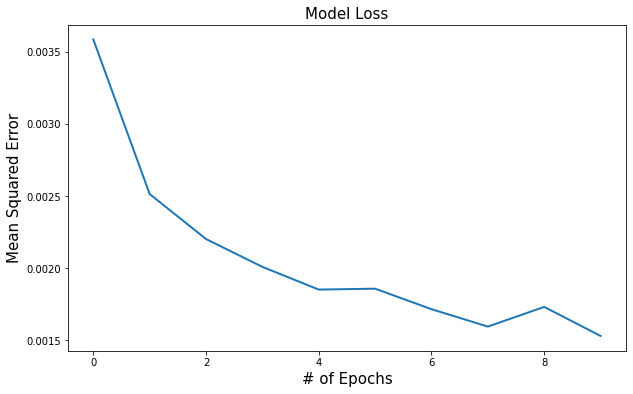

In [235]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], linewidth=2)
plt.title('Model Loss', fontsize=15)
plt.xlabel('# of Epochs', fontsize=15)
plt.ylabel('Mean Squared Error', fontsize=15)

## Forecast Using LSTM

In [236]:
X_train_forecast = scaler.inverse_transform(model.predict(X_train))
y_train = scaler.inverse_transform([y_train.ravel()])
X_test_forecast = scaler.inverse_transform(model.predict(X_test))
y_test = scaler.inverse_transform([y_test.ravel()])

1/1 [==============================] - 0s 19ms/step


In [237]:
y_test

array([[222838.6, 220297.4, 216988.1, 215716.9, 214446.7, 211270.1,
        208695.4, 202717.8, 206075.8, 204914.5, 202824.7, 200216.9,
        195319.2, 192680.2, 190344.8, 189205. , 186696.3, 185435.8,
        180701.5, 177700.7, 176654.4]])

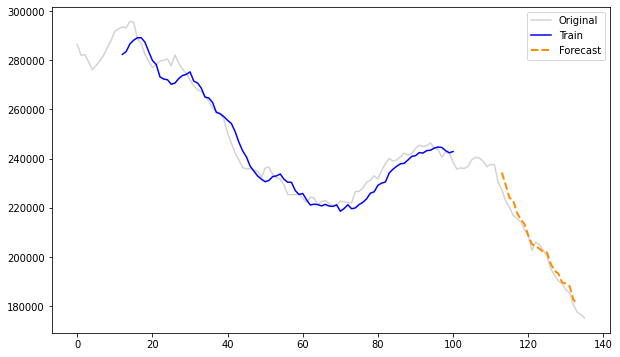

In [241]:
plt.figure(figsize=(10,6))

# Plot original dataset:
plt.plot(list(range(0, len(ds))), scaler.inverse_transform(ds), label="Original", color="lightgrey")

# Plot training data:
train_y_plot = X_train_forecast
train_x_plot = [i+lookback for i in list(range(0, len(X_train_forecast)))]
plt.plot(train_x_plot, train_y_plot , label="Train", color="blue")

# Plot forecasted data:
test_y_plot = X_test_forecast
test_x_plot = [i+lookback*2 for i in list(range(len(X_train_forecast), len(X_train_forecast)+len(X_test_forecast)))]
plt.plot(test_x_plot, test_y_plot , label="Forecast", color="darkorange", linewidth=2, linestyle="--")

plt.legend()